<a href="https://colab.research.google.com/github/zolfaShefreie/Heating-Cooling-Load-Prediction/blob/main/EnergyEfficiency_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

#Download Dataset

In [3]:
def download_file(url: str, file_path):
  """
  download file and save on file path
  """
  file_content = requests.get(url).text
  file = open(file_path, 'w')
  file.write(file_content)
  file.close()

In [4]:
train_url = 'https://raw.githubusercontent.com/zolfaShefreie/Heating-Cooling-Load-Prediction/main/01.train.csv'
test_url = 'https://raw.githubusercontent.com/zolfaShefreie/Heating-Cooling-Load-Prediction/main/02.test.csv'

train_file_path = "train.csv"
test_file_path = "test.csv"

In [5]:
download_file(train_url, train_file_path)
download_file(test_url, test_file_path)

#Load Dataset

In [6]:
train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)

In [7]:
train_df.shape, test_df.shape

((668, 10), (100, 10))

#Analyse Dataset

برای آنالیز داده دو مجموعه داده را با یکدیگر ادغام می‌کنیم تا نتایج بررسی شود

In [8]:
total_df = train_df.append(test_df, ignore_index=True)
total_df.shape

(768, 10)

مقادیر نال در مجموعه داده وجود ندارد

In [9]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Relative_Compactness       768 non-null    float64
 1   Surface_Area               768 non-null    float64
 2   Wall_Area                  768 non-null    float64
 3   Roof_Area                  768 non-null    float64
 4   Overall_Height             768 non-null    float64
 5   Orientation                768 non-null    int64  
 6   Glazing_Area               768 non-null    float64
 7   Glazing_Area_Distribution  768 non-null    int64  
 8   Heating_Load               768 non-null    float64
 9   Cooling_Load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


مقادیر اوت لایر و غیر عادی دیده نمی شود

In [10]:
total_df.describe()

,Relative_Compactness,Surface_Area,Wall_Area,Roof_Area,Overall_Height,Orientation,Glazing_Area,Glazing_Area_Distribution,Heating_Load,Cooling_Load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307201,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090196,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


تمام ستون‌ها به جز ستون‌های برچسب حالت کتگوریکال دارند یعنی عناصر یونیک آنها محدوده این موارد ممکن به علت وجود استاندارد خاص باشد و امکان گسسته سازی آن نیز وجود دارد

In [11]:
for column in total_df.columns:
  print(column, " ",total_df[column].unique())

Relative_Compactness   [0.76 0.98 0.74 0.9  0.86 0.62 0.82 0.69 0.66 0.71 0.64 0.79]
Surface_Area   [661.5 514.5 686.  563.5 588.  808.5 612.5 735.  759.5 710.5 784.  637. ]
Wall_Area   [416.5 294.  245.  318.5 367.5 269.5 343. ]
Roof_Area   [122.5  110.25 220.5  147.  ]
Overall_Height   [7.  3.5]
Orientation   [2 4 5 3]
Glazing_Area   [0.4  0.25 0.1  0.  ]
Glazing_Area_Distribution   [1 5 3 2 4 0]
Heating_Load   [40.78 28.37 10.36 29.83 29.43 16.76 22.58 16.44 14.08 12.41 33.12 32.31
 24.63 14.72 11.69 14.66 11.2  10.39 12.12 19.68 29.06 11.16 23.93 14.6
 29.68 17.88 14.53 35.48 24.23 39.97 15.55 13.97 14.4  19.   32.06 42.96
 14.5  18.88 10.75 40.6  28.55 31.53 35.73 11.42 10.07 28.09 35.01 38.98
 36.66 29.34 29.54 12.17 23.53 18.9  29.27 32.84 11.43 32.46 35.96 39.86
 16.94 15.42 16.84 15.16 24.17 32.12 11.49  8.6  32.94 10.47 32.67 12.8
 41.26 14.19 33.28 32.52  6.37 14.75 35.69 14.17 32.68 15.41 28.7  12.63
 42.74 20.71 15.3  36.28 10.43 38.57 39.83 24.4  12.18 28.41 11.45 14.58
 

رابطه‌هایی بین موارد زیر دیده می‌شود که نیاز به بررسی بیشتر دارد:<br/>


*   relative_Compactness and surface area
*   relative_Compactness and roof area
*   relative_Compactness and overall height
*   surface area and overall height
*   surface area and roof area
*   roof area and heating load and cooling load
*   roof area and overall height
*   overall height and heating load and cooling load



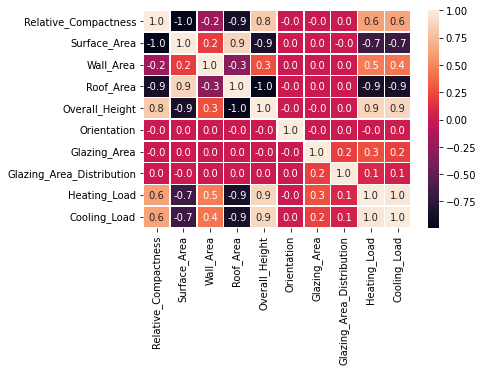

In [12]:
sns.heatmap(total_df.corr(), annot=True, linewidths=.5, fmt= '.1f')

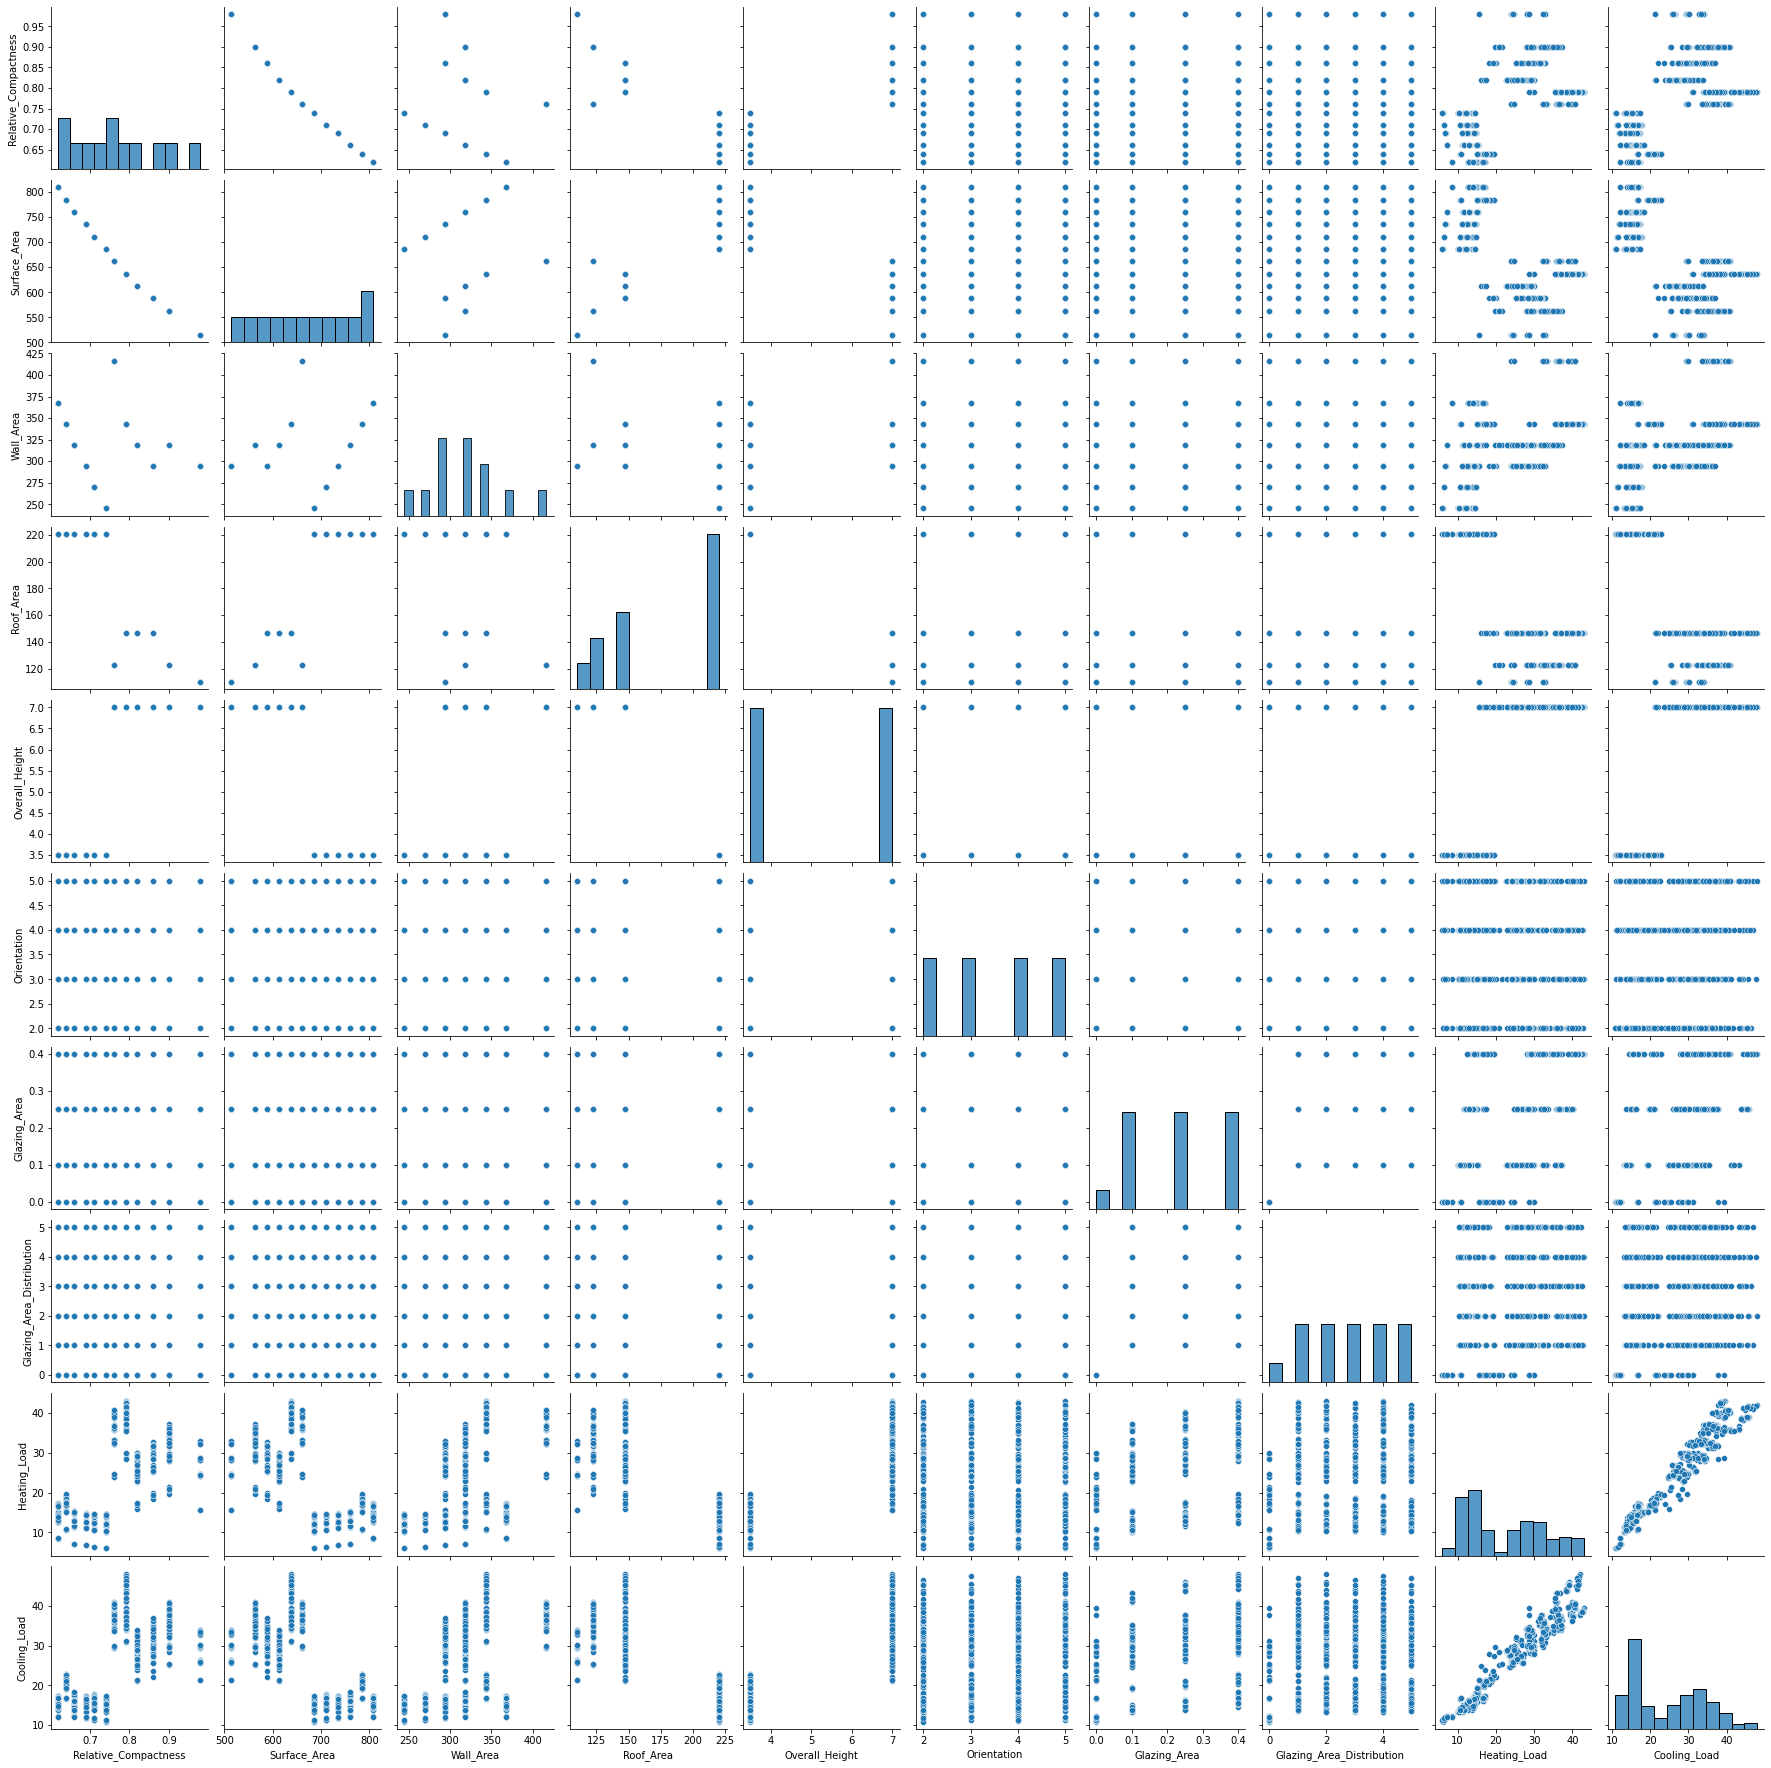

In [13]:
sns.pairplot(total_df)

In [14]:
total_df.columns

Index(['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
       'Overall_Height', 'Orientation', 'Glazing_Area',
       'Glazing_Area_Distribution', 'Heating_Load', 'Cooling_Load'],
      dtype='object')

## Relative_Compactness and Surface_Area and Roof_Area and Overall_Height

همانطور که در شکل زیر مشاهده می‌شود هرچه سرفیس بیشتر می‌شود ریلتیو کامپتنس کمتر می‌شود و هر مقدار از آنها را می‌توان به یکدیگر مپ کرد و از هر کدام دقیقا ۶۴ مورد موجود است

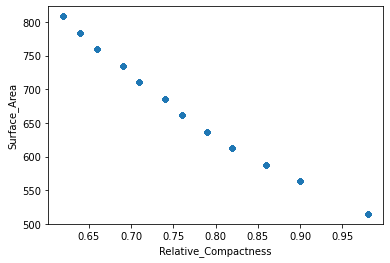

In [15]:
total_df.plot.scatter('Relative_Compactness', 'Surface_Area')

In [16]:
total_df[['Relative_Compactness', "Surface_Area"]].groupby(['Relative_Compactness', "Surface_Area"]).size()

Relative_Compactness  Surface_Area
0.62                  808.5           64
0.64                  784.0           64
0.66                  759.5           64
0.69                  735.0           64
0.71                  710.5           64
0.74                  686.0           64
0.76                  661.5           64
0.79                  637.0           64
0.82                  612.5           64
0.86                  588.0           64
0.90                  563.5           64
0.98                  514.5           64
dtype: int64

چند دسته از ریلتت کامپکتنس در یک دسته از روف اریا قرار می‌گیرد و در بیشتر حالت‌ها با افزایش روف اریا، ریلیتت کامپکتنس هم افزایش می‌یابد

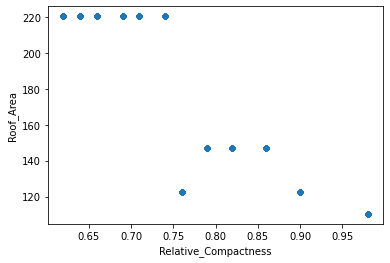

In [17]:
total_df.plot.scatter('Relative_Compactness', 'Roof_Area')

In [18]:
total_df[['Relative_Compactness', "Roof_Area"]].groupby(['Relative_Compactness', "Roof_Area"]).size()

Relative_Compactness  Roof_Area
0.62                  220.50       64
0.64                  220.50       64
0.66                  220.50       64
0.69                  220.50       64
0.71                  220.50       64
0.74                  220.50       64
0.76                  122.50       64
0.79                  147.00       64
0.82                  147.00       64
0.86                  147.00       64
0.90                  122.50       64
0.98                  110.25       64
dtype: int64

چند دسته از سرفیس اریا در یک دسته از روف اریا قرار می‌گیرند که در بیشتر موارد رابطه‌ی مستیقیم با یکدیگر دارند

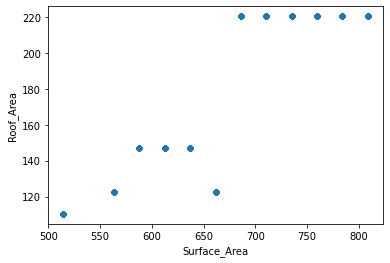

In [19]:
total_df.plot.scatter('Surface_Area', 'Roof_Area')

In [20]:
total_df[['Roof_Area', "Surface_Area"]].groupby(['Roof_Area', "Surface_Area"]).size()

Roof_Area  Surface_Area
110.25     514.5           64
122.50     563.5           64
           661.5           64
147.00     588.0           64
           612.5           64
           637.0           64
220.50     686.0           64
           710.5           64
           735.0           64
           759.5           64
           784.0           64
           808.5           64
dtype: int64

اورال هایت دو دسته دارد که موارد دیگر در این دو دسته تقسیم می‌شوند

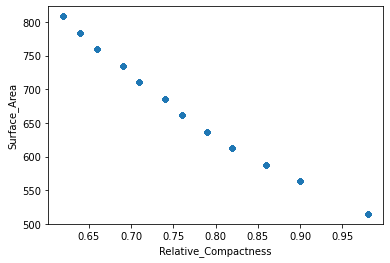

In [21]:
total_df.plot.scatter('Relative_Compactness', 'Surface_Area')

In [22]:
total_df[['Relative_Compactness', "Overall_Height"]].groupby(['Overall_Height', "Relative_Compactness"]).size()

Overall_Height  Relative_Compactness
3.5             0.62                    64
                0.64                    64
                0.66                    64
                0.69                    64
                0.71                    64
                0.74                    64
7.0             0.76                    64
                0.79                    64
                0.82                    64
                0.86                    64
                0.90                    64
                0.98                    64
dtype: int64

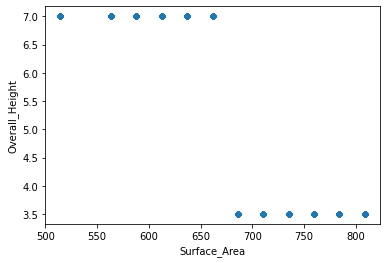

In [23]:
total_df.plot.scatter('Surface_Area', 'Overall_Height')

In [24]:
total_df[['Surface_Area', "Overall_Height"]].groupby(['Overall_Height', "Surface_Area"]).size()

Overall_Height  Surface_Area
3.5             686.0           64
                710.5           64
                735.0           64
                759.5           64
                784.0           64
                808.5           64
7.0             514.5           64
                563.5           64
                588.0           64
                612.5           64
                637.0           64
                661.5           64
dtype: int64

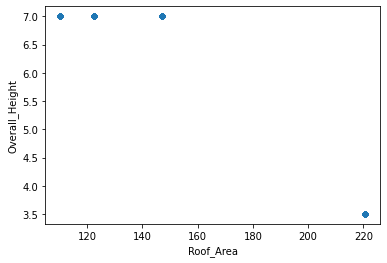

In [25]:
total_df.plot.scatter('Roof_Area', 'Overall_Height')

In [26]:
total_df[['Roof_Area', "Overall_Height"]].groupby(['Overall_Height', "Roof_Area"]).size()

Overall_Height  Roof_Area
3.5             220.50       384
7.0             110.25        64
                122.50       128
                147.00       192
dtype: int64

##realations with targets

#Predictions

##heating loading

###Preprocess Data

به‌دلیل تناظر یک به یک ریلیتیو کامپکتنس و سرفیس اریا یکی از آن‌ها می‌تواند حذف شود که در اینجا سرفیس اریا حذف شده است.

In [27]:
x_train = train_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_train = train_df[['Heating_Load']].copy()

x_test = test_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_test = test_df[['Heating_Load']].copy()

بار بالا به عنوان ۱ و بار پایین به‌عنوان بار پایین گذاشته می‌شوند

In [28]:
y_train.loc[y_train['Heating_Load'] < 18, 'Heating_Load'] = 0
y_train.loc[y_train['Heating_Load'] >= 18, 'Heating_Load'] = 1

y_test.loc[y_test['Heating_Load'] < 18, 'Heating_Load'] = 0
y_test.loc[y_test['Heating_Load'] >= 18, 'Heating_Load'] = 1

In [29]:
y_train.Heating_Load.unique()

array([1., 0.])

In [30]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

###Decision Tree

####Train Model

In [31]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(x_train, y_train.Heating_Load)

DecisionTreeClassifier()

####Evaluate Model

In [32]:
y_predict = dtc_model.predict(x_test)

In [33]:
confusion_matrix(y_test.Heating_Load, y_predict)

array([[44,  1],
       [ 0, 55]])

In [34]:
print(classification_report(y_test.Heating_Load, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        45
         1.0       0.98      1.00      0.99        55

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [35]:
accuracy_score(y_test.Heating_Load, y_predict)

0.99

In [36]:
1 - accuracy_score(y_test.Heating_Load, y_predict)

0.010000000000000009

In [37]:
f1_score(y_test.Heating_Load, y_predict)

0.9909909909909909

###Random Forest

####Train Model

In [38]:
rfc_model = RandomForestClassifier()
rfc_model.fit(x_train, y_train.Heating_Load)

RandomForestClassifier()

####Evaluate Model

In [39]:
y_predict = rfc_model.predict(x_test)

In [40]:
confusion_matrix(y_test.Heating_Load, y_predict)

array([[44,  1],
       [ 0, 55]])

In [41]:
print(classification_report(y_test.Heating_Load, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        45
         1.0       0.98      1.00      0.99        55

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



In [42]:
accuracy_score(y_test.Heating_Load, y_predict)

0.99

In [43]:
1 - accuracy_score(y_test.Heating_Load, y_predict)

0.010000000000000009

In [44]:
f1_score(y_test.Heating_Load, y_predict)

0.9909909909909909

## cooling loading

###Preprocess Data

In [45]:
x_train = train_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_train = train_df[['Cooling_Load']].copy()

x_test = test_df[['Relative_Compactness', 'Wall_Area', 'Roof_Area',
                    'Overall_Height', 'Orientation', 'Glazing_Area',
                    'Glazing_Area_Distribution']].copy()
y_test = test_df[['Cooling_Load']].copy()


In [46]:
x_train.shape

(668, 7)

In [47]:
bins = pd.cut(total_df.Cooling_Load, 5, retbins=True)[1]
bins

array([10.86287, 18.326  , 25.752  , 33.178  , 40.604  , 48.03   ])

In [48]:
y_train['Cooling_Load'] = pd.cut(y_train.Cooling_Load, bins=bins, labels=[i for i in range(5)])
y_test['Cooling_Load'] = pd.cut(y_test.Cooling_Load, bins=bins, labels=[i for i in range(5)])

In [49]:
y_train

,Cooling_Load
0,3
1,2
2,0
3,2
4,2
...,...
663,3
664,2
665,0
666,2


In [50]:
y_train.shape

(668, 1)

In [51]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [52]:
# scaler = MinMaxScaler()
# y_train = scaler.fit_transform(y_train.Cooling_Load)
# y_test = scaler.transform(y_test.Cooling_Load)

###SVM

####tain model

In [53]:
svm = SVC()
svm.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()

####evaluate model

In [54]:
y_predict = svm.predict(x_test)

In [55]:
confusion_matrix(y_test.Cooling_Load, y_predict)

array([[37,  0,  0,  0,  0],
       [10,  0,  4,  0,  0],
       [ 0,  0, 16,  3,  0],
       [ 0,  0,  9, 16,  0],
       [ 0,  0,  3,  2,  0]])

In [56]:
print(classification_report(y_test.Cooling_Load, y_predict))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        37
           1       0.00      0.00      0.00        14
           2       0.50      0.84      0.63        19
           3       0.76      0.64      0.70        25
           4       0.00      0.00      0.00         5

    accuracy                           0.69       100
   macro avg       0.41      0.50      0.44       100
weighted avg       0.58      0.69      0.62       100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
accuracy_score(y_test.Cooling_Load, y_predict)

0.69

In [58]:
1 - accuracy_score(y_test.Cooling_Load, y_predict)

0.31000000000000005

In [59]:
f1_score(y_test.Cooling_Load, y_predict, average='micro')

0.69

###neural network

####Preprocess Data

In [60]:
y_train_n = tf.keras.utils.to_categorical(y_train.Cooling_Load)
y_test_n = tf.keras.utils.to_categorical(y_test.Cooling_Load)

In [61]:
y_train_n.shape

(668, 5)

####train model

In [62]:
input_model = tf.keras.layers.Input(shape=(7, ))
dense_1 = tf.keras.layers.Dense(units=128, activation='relu')(input_model)
dense_2 = tf.keras.layers.Dense(units=64, activation='relu')(dense_1)
dense_3 = tf.keras.layers.Dense(units=20, activation='relu')(dense_2)
dense_4 = tf.keras.layers.Dense(5, activation='softmax')(dense_3)
model = tf.keras.models.Model(inputs=input_model, outputs=dense_4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
model.fit(x=x_train, y=y_train_n, epochs=100)

Epoch 1/150
21/21 [==============================] - 1s 2ms/step - loss: 1.4389 - accuracy: 0.4731
Epoch 2/150
21/21 [==============================] - 0s 2ms/step - loss: 1.0860 - accuracy: 0.6901
Epoch 3/150
21/21 [==============================] - 0s 2ms/step - loss: 0.8340 - accuracy: 0.7335
Epoch 4/150
21/21 [==============================] - 0s 2ms/step - loss: 0.7369 - accuracy: 0.7171
Epoch 5/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.7320
Epoch 6/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6520 - accuracy: 0.7246
Epoch 7/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6191 - accuracy: 0.7425
Epoch 8/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6033 - accuracy: 0.7365
Epoch 9/150
21/21 [==============================] - 0s 2ms/step - loss: 0.6108 - accuracy: 0.7201
Epoch 10/150
21/21 [==============================] - 0s 3ms/step - loss: 0.5943 - accuracy: 0.7290
Epoch 11/

####Evaluate model

In [64]:
model.evaluate(x_test, y_test_n, verbose=0)

[0.2790658175945282, 0.8799999952316284]